In [1]:
# import libraries
import pandas as pd
import numpy as np
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer
import matplotlib.pyplot as plt
import seaborn as sns
import regex as re
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import GaussianNB, BernoulliNB, MultinomialNB
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, classification_report
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

# Data Science Process
---

1. Define the problem.
2. Obtain the data.
3. Explore the data.
4. **Model the data.**
5. **Evaluate the model.**
6. **Answer the problem.**

**Create and compare two models**. One of these must be a Bayes classifier, however the other can be a classifier of your choosing: logistic regression, KNN, SVM, etc.

In [2]:
# Import datasets
canon = pd.read_csv('./data/canon_merge.csv')
nikon = pd.read_csv('./data/nikon_merge.csv')
sony = pd.read_csv('./data/sony_merge.csv')
photo = pd.read_csv('./data/photo.csv')
photo.head(2)

,Unnamed: 0,selftext,subreddit,title,combo
0,0,NaN,1,"From a shoot last summer on the XC15, call me ...","NA From a shoot last summer on the XC15, call ..."
1,1,So even though my Cannon MG7720 printer says i...,1,Unable To Get Cannon 7720 Connected Wifi,So even though my Cannon MG7720 printer says i...


## Model 1
---
**Count Vectoirzer and Logistic Regression on Title Text**

In [3]:
# Declare variables
dep = photo['subreddit']
indep = photo['title']

#Train, test, split
indep_train, indep_test, dep_train, dep_test = train_test_split(indep,
                                                    dep,
                                                    test_size=0.3,
                                                    stratify=dep,
                                                    random_state=42)


# We are going to pipeline it for CountVectorizer
pipe = Pipeline([
    ('cvec', CountVectorizer()),
    ('lr', LogisticRegression())
])

pipe_params = {
    'cvec__max_features' : [100, 500, 1000],
    'cvec__ngram_range' : [(1, 1), (1, 2), (1,3)],
    'cvec__stop_words' : ['english', None]
} 

# Instantiate GridSearchCV.

gs = GridSearchCV(pipe, # what object are we optimizing?
                  pipe_params, # what parameters values are we searching?
                  cv = 5, # 5-fold cross-validation.
                  n_jobs=6) 

# Fit GridSearch to training data.
gs1 = gs.fit(indep_train, dep_train)


In [4]:
# Save best model as gs_model.
gs_model = gs1.best_estimator_
gs_model

Pipeline(memory=None,
         steps=[('cvec',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=1000, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words='english', strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=None)),
                ('lr',
                 LogisticRegression(C=1.0, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=100,
                                    multi_class='auto', n_jobs=None,
                      

In [5]:
# Displaying scores for train and test sets
print(gs_model.score(indep_train, dep_train))
print(gs_model.score(indep_test, dep_test))

0.9707142857142858
0.8916666666666667


In [6]:
# Checking for best parameters
gs.best_params_

{'cvec__max_features': 1000,
 'cvec__ngram_range': (1, 1),
 'cvec__stop_words': 'english'}

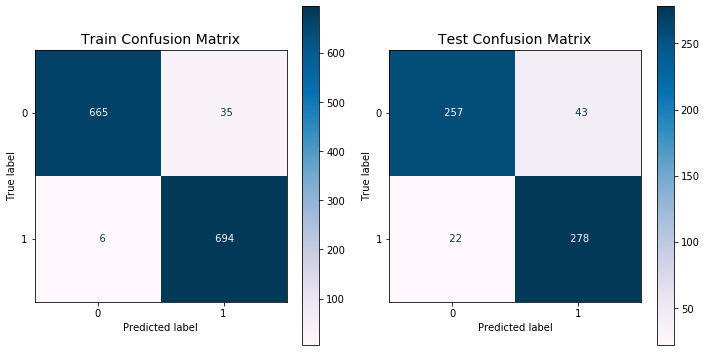

In [7]:
# Plot cunfusion matrixs for test and train data.
fig = plt.figure(figsize=(10,5))
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)

plot_confusion_matrix(gs, 
                      indep_train, 
                      dep_train, 
                      cmap="PuBu", 
                      values_format='4g',
                      ax=ax1);
ax1.set_title('Train Confusion Matrix', fontsize=14);

plot_confusion_matrix(gs, 
                      indep_test, 
                      dep_test, 
                      cmap="PuBu", 
                      values_format='4g',
                      ax=ax2);
ax2.set_title('Test Confusion Matrix', fontsize=14);
plt.tight_layout()

In [8]:
# Getting preds and running classification report for the best model
preds_te = gs.predict(indep_test)
print(classification_report(dep_test, preds_te))

              precision    recall  f1-score   support

           0       0.92      0.86      0.89       300
           1       0.87      0.93      0.90       300

    accuracy                           0.89       600
   macro avg       0.89      0.89      0.89       600
weighted avg       0.89      0.89      0.89       600



In [9]:
# Extracting features and coefficients from the model
logreg = gs.best_estimator_.named_steps['lr']
odds = np.exp(logreg.coef_).T
words = gs.best_estimator_.named_steps['cvec'].vocabulary_
coeffs = pd.DataFrame.from_dict(words, orient='index', columns=['Word'])


coeffs['Odds'] = odds
coeffs = coeffs.sort_values(['Odds'], ascending=False)
coeffs.head()

,Word,Odds
card,231,21.544840
bird,192,11.261387
installing,512,4.702170
tell,895,3.449999
good,457,3.414057


#### This model predicts that the words card and picture will be highly predictive of a Canon reddti post.

# Model 2
---
**TFIDF Vectoirzer and Bernoulli Naive Bays on Title Text**

In [10]:
# We are going to pipeline it for CountVectorizer
pipe = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('mn', BernoulliNB())
])

pipe_params = {
    'tvec__max_features' : [100, 500, 1000],
    'tvec__ngram_range' : [(1, 1), (1, 2), (1,3)],
    'tvec__stop_words' : ['english', None]
} 

# Instantiate GridSearchCV.

gs = GridSearchCV(pipe, # what object are we optimizing?
                  pipe_params, # what parameters values are we searching?
                  cv = 5) # 5-fold cross-validation.

# Fit GridSearch to training data.
model_mn = gs.fit(indep_train, dep_train)



In [11]:
# Displaying scores for train and test sets
print(model_mn.score(indep_train, dep_train))
print(model_mn.score(indep_test, dep_test))

0.9057142857142857
0.8933333333333333


In [12]:
# Checking for best parameters
model_mn.best_params_

{'tvec__max_features': 500,
 'tvec__ngram_range': (1, 1),
 'tvec__stop_words': 'english'}

In [13]:
# Save best model as gs_model.
model_mn_b = model_mn.best_estimator_
model_mn_b

Pipeline(memory=None,
         steps=[('tvec',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=500,
                                 min_df=1, ngram_range=(1, 1), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words='english', strip_accents=None,
                                 sublinear_tf=False,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, use_idf=True,
                                 vocabulary=None)),
                ('mn',
                 BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None,
                             fit_prior=True))],
         verbose=False)

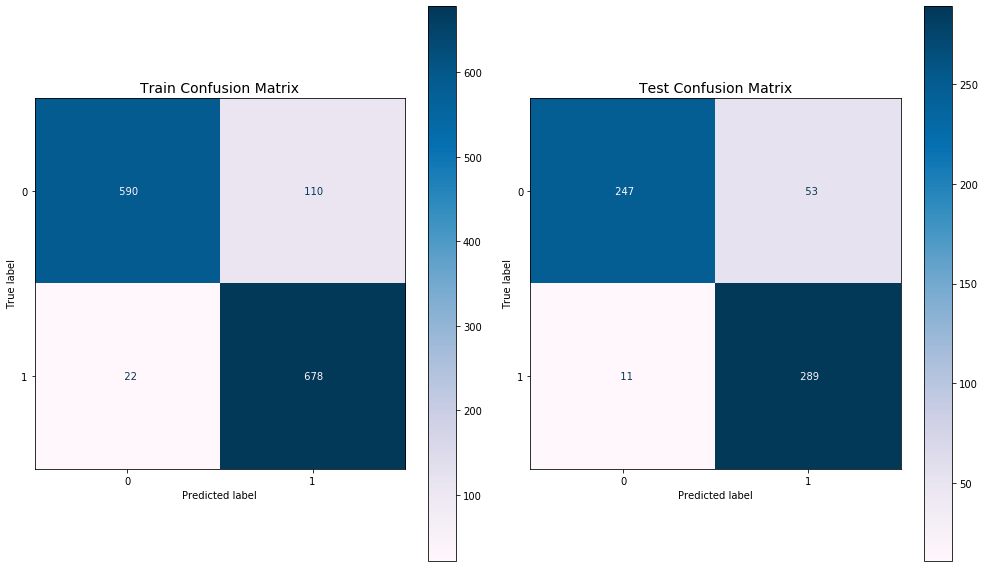

In [14]:
# Generate predictions.
preds = model_mn.predict(indep_test)
# Confusion Matrix
fig = plt.figure(figsize=(14,8))
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)

plot_confusion_matrix(model_mn, 
                      indep_train, 
                      dep_train, 
                      cmap="PuBu", 
                      values_format='4g',
                      ax=ax1);
ax1.set_title('Train Confusion Matrix', fontsize=14);

plot_confusion_matrix(model_mn, 
                      indep_test, 
                      dep_test, 
                      cmap="PuBu", 
                      values_format='4g',
                      ax=ax2);
ax2.set_title('Test Confusion Matrix', fontsize=14);
plt.tight_layout()

In [15]:
# Getting preds and running classification report for the best model
preds_te = model_mn.predict(indep_test)
print(classification_report(dep_test, preds))

              precision    recall  f1-score   support

           0       0.96      0.82      0.89       300
           1       0.85      0.96      0.90       300

    accuracy                           0.89       600
   macro avg       0.90      0.89      0.89       600
weighted avg       0.90      0.89      0.89       600



# Model 3
---
**Count Vectoirzer and Logistic Regression on Combination Text**

In [16]:
# Declare variables
dep = photo['subreddit']
indep = photo['combo']

#Train, test, split
indep_train, indep_test, dep_train, dep_test = train_test_split(indep,
                                                    dep,
                                                    test_size=0.3,
                                                    stratify=dep,
                                                    random_state=42)


# We are going to pipeline it for CountVectorizer
pipe = Pipeline([
    ('cvec', CountVectorizer()),
    ('lr', LogisticRegression())
])

pipe_params = {
    'cvec__max_features' : [100, 500, 1000],
    'cvec__ngram_range' : [(1, 1), (1, 2), (1,3)],
    'cvec__stop_words' : ['english', None]
} 

# Instantiate GridSearchCV.

gs = GridSearchCV(pipe, # what object are we optimizing?
                  pipe_params, # what parameters values are we searching?
                  cv = 5,     # 5-fold cross-validation.
                 n_jobs=6) 

# Fit GridSearch to training data.
gs2 = gs.fit(indep_train, dep_train)


In [17]:
# Checking for best parameters
gs_model = gs2.best_estimator_
gs_model

Pipeline(memory=None,
         steps=[('cvec',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=1000, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=None)),
                ('lr',
                 LogisticRegression(C=1.0, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=100,
                                    multi_class='auto', n_jobs=None,
                           

In [18]:
# Displaying scores for train and test sets
print(gs_model.score(indep_train, dep_train))
print(gs_model.score(indep_test, dep_test))

0.985
0.9133333333333333


In [19]:
# Checking for best parameters
gs2.best_params_

{'cvec__max_features': 1000,
 'cvec__ngram_range': (1, 1),
 'cvec__stop_words': None}

In [20]:
# Extracting features and coefficients from the model
logreg = gs.best_estimator_.named_steps['lr']
odds = np.exp(logreg.coef_).T
words = gs.best_estimator_.named_steps['cvec'].vocabulary_
coeffs = pd.DataFrame.from_dict(words, orient='index', columns=['Count'])


coeffs['Odds'] = odds
coeffs = coeffs.sort_values(['Odds'], ascending=False)
coeffs.head()

,Count,Odds
price,670,18.097406
gets,392,9.453283
320,46,4.504765
unable,910,3.578014
sd,743,3.318328


In [21]:
# This shows the values most indicating Nikon
coeffs.tail()  

,Count,Odds
product,678,0.196040
picture,647,0.165179
we,948,0.125780
smid,790,0.091865
iv,474,0.044783


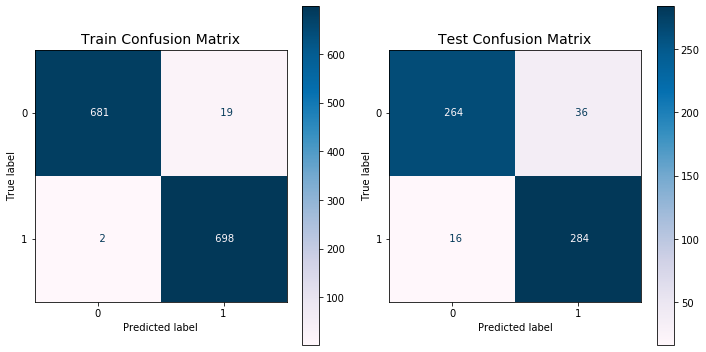

In [22]:
# Generate predictions for test.
#preds_te = gs.predict(indep_test)
fig = plt.figure(figsize=(10,5))
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)

plot_confusion_matrix(gs2, 
                      indep_train, 
                      dep_train, 
                      cmap="PuBu", 
                      values_format='4g',
                      ax=ax1);
ax1.set_title('Train Confusion Matrix', fontsize=14);

plot_confusion_matrix(gs2, 
                      indep_test, 
                      dep_test, 
                      cmap="PuBu", 
                      values_format='4g',
                      ax=ax2);
ax2.set_title('Test Confusion Matrix', fontsize=14);
plt.tight_layout()

In [23]:
# Getting preds and running classification report for the best model
preds = gs2.predict(indep_test)
print(classification_report(dep_test, preds))

              precision    recall  f1-score   support

           0       0.94      0.88      0.91       300
           1       0.89      0.95      0.92       300

    accuracy                           0.91       600
   macro avg       0.92      0.91      0.91       600
weighted avg       0.92      0.91      0.91       600



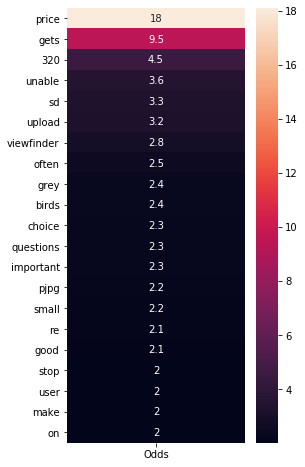

In [24]:
# Looking at top preforming features that indicate a Canon post
coeffs1 = coeffs.drop(labels='Count', axis=1)
top_features = coeffs1[coeffs1["Odds"] > 2]

plt.figure(figsize=(4,8))
sns.heatmap(top_features.sort_values('Odds', ascending=False), annot=True);

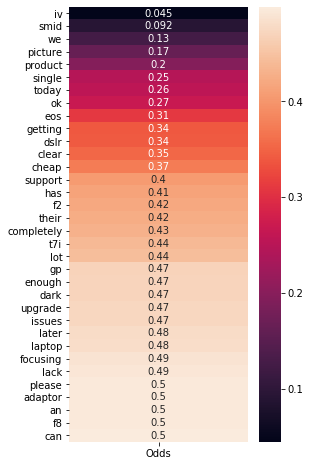

In [25]:
# Looking at top preforming features that indicate a Nikon post
bot_features = coeffs1[coeffs1["Odds"] < .5]


plt.figure(figsize=(4,8))
sns.heatmap(bot_features.sort_values('Odds'), annot=True);